# Final Project

## Names: Sophia Hillard & Campbell Linker

- Insert Markdown chunks for your written responses as needed
- Do not include unnecessary code. Only code that is needed to answer the questions should be included, nothing more. 
- Be sure your work is **reproducible** by "Restart and Clear Output" then "Run All" cells
- The group leader will make a single submission on Moodle on behalf of the group. 
- **ACKNOWELDGE ALL EXTERNAL SOURCES HERE:** Give a brief summary of any external sources you used. Ex:
    - https://pankaj8blr.medium.com/eda-and-significance-of-various-plots-in-feature-engineering-f8cededbd520
    - https://seaborn.pydata.org/generated/seaborn.boxplot.html
    - Google AI overview for XXX
    - StackOverflow for YYY

In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import math
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import re
from spellchecker import SpellChecker
import seaborn as sns
import warnings   # We will turn of the future warnings that xgboost gives us
warnings.simplefilter(action='ignore', category=FutureWarning)
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.decomposition import PCA
from sklearn.pipeline import FeatureUnion
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV

import warnings   
warnings.simplefilter(action='ignore', category=FutureWarning)

## 1. The Data

The dataset we chose is [LLM - Detect AI Generated Text](https://www.kaggle.com/competitions/llm-detect-ai-generated-text/overview) where:

* Outcome variable: Binary, AI generated (1) or human generated (0)
* Predictor variables: -- all created through feature engineering of essay text
* Number of observations:
    * Training set: $n_{train} = 9000$ ($1000$ from competition training set, $8000$ from [reccomended external source](https://www.kaggle.com/datasets/thedrcat/daigt-v2-train-dataset))
    * Test set: $n_{test} = 9000$
* Score/metric used for the [leaderboard](https://www.kaggle.com/competitions/llm-detect-ai-generated-text/leaderboard): Submissions are evaluated on area under the ROC curve between the predicted probability and the observed target.

In [65]:
# Load all datasets here. 
train = pd.read_csv("data/train_WORK.csv", sep=',', index_col = 'id')
# test_essays = pd.read_csv('/kaggle/input/llm-detect-ai-generated-text/test_essays.csv', index_col='id')



# train_essay, test_essay = train_test_split(train, test_size=0.3, random_state=38)

## Separate outcome
# train_essay_y = train_essay['generated']
# train_essay_X = train_essay['text']
# test_essay_y = test_essay['generated']
# test_essay_X = test_essay['text']

# train_y = train['generated']
# train_X = train['text']

**Explanation of actual test data:**

As noted to Prof. Kim, our Kaggle submission format was different from that specified in the pynb. We could not upload a csv but had to upload code into kaggle that would render a csv. I included components of the code we used to generate our actual test predictions in kaggle, but had to comment them out so that this pynb would run without errors. 

## 2. Exploratory Data Analysis

Perform all necessary EDA here. Before submitting, only keep those you feel are relevant

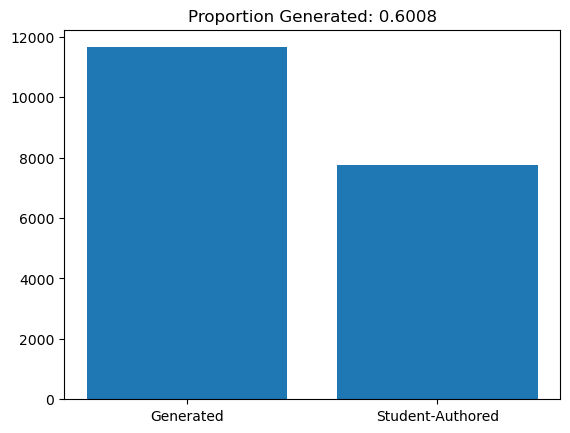

In [6]:
# Univariate visualization of outcome variable:
y_train_cat = train_essay_y.map({1: 'Generated', 0: 'Student-Authored'})
category_counts = pd.Series(y_train_cat).value_counts()
plt.bar(x = category_counts.index, height = category_counts.values)
prop_gen = train_essay_y.mean()
plt.title("Proportion Generated: " + str(f"{prop_gen:.4f}"))
plt.show()

## 3. Feature Engineering

Perform your feature engineering here and then create `y_train`, `X_train` and `X_test`. 

In [67]:
# Define inputs for variables 

input_transition = ["first", "firstly", "second", "secondly", "third", "thirdly", "meanwhile", "previously", "subsequently", "eventually", 
                    "finally", "lastly", "ultimately", "conclusion", "addition", "additionally", "furthermore", "moreover", "besides", 
                    "equally", "however", "contrary", "conversely", "despite", "contrast", "nevertheless", "nonetheless", "whereas", "while",
                    "although", "though", "therefore", "thus", "hence", "consequently", "accordingly", "namely", "specifically", "indeed", 
                    "importantly", "significantly", "especially", "notably", "undoubtedly", "likewise", "similarly", "correspondingly", "sum",
                    "summary", "overall", "conclude", "conclusion", "simultaneously", "formerly", "lately", "recently", "opposite", "adjacent",
                    "provided", "admittedly", "regarding"]

input_hyperbole = ["powerful", "groundbreaking", "illuminating", "vital", "invaluable", "indelible", "essential", "poignant", "profound", 
                   "remarkable", "transformative", "revolutionary", "unparalleled", "extraordinary", "compelling", "significant", "exceptional",
                   "crucial", "monumental", "dramatic", "robust", "innovative", "pivotal", "impressive", "astonishing", "visionary", "inspiring",
                   "striking", "dynamic", "iconic", "seminal", "trailblazing", "revolutionary", "extreme", "shocking"]

input_abn_symbols = ["[", "]", "_", "*", "<", ">", "{", "}", "^", "@", "#", "|", "\\"]

input_prompt_lang = ["here you go", "as an ai", "as a language model", "i generated", "here's the essay", "here's your essay", "let me", 
                     "help you", "sure,", "i hope this helps", "your prompt", "your request", "here is", "here's", "sure!", 
                     "here is the essay", "here is your essay", "language model", "large language", "llm", "generative ai", "chatbot", 
                     "your essay"]

In [69]:
# Create functions for feature engineering 

### Spelling errors
spell = SpellChecker()

def clean_text_for_spellcheck(text):
    if pd.isna(text):
        return ""
    for symbol in input_abn_symbols:
        text = text.replace(symbol, "")
    text = re.sub(r"[^a-z\s'-]", "", text.lower())
    return text

def misspelling_ratio(text):
    text_clean = clean_text_for_spellcheck(text)
    words = text_clean.split()
    if len(words) == 0:
        return 0.0 
    misspelled = spell.unknown(words)
    return len(misspelled) / len(words)

def count_misspellings(text):
    text_clean = clean_text_for_spellcheck(text)
    words = text_clean.split()
    if len(words) == 0:
        return 0
    misspelled = spell.unknown(words)
    return len(misspelled)

### Exclamation points
def count_exclamation_points(text):
    return text.count('!')


### Em dashes
def count_em_dash(text):
    return text.count('—')


### Transitional words
def count_transition(text):
    return sum(text.count(word) for word in input_transition)


### Hyperbolic phrasing
def count_hyperbolic(text):
    return sum(text.count(word) for word in input_hyperbole)


### Abnormal symbols
def count_abn_symbols(text):
    return sum(text.count(word) for word in input_abn_symbols)


## Prompt indicator
def contains_prompt_indicators(text):
    return sum(text.count(word) for word in input_prompt_lang)

In [73]:
# Add features to both training AND competition test data

def add_features(df):
    # making sure to include a step that makes all text lowercase so that features can be applied
    df["text"] = df["text"].str.lower()  
    df["misspelling_ratio"] = df["text"].apply(misspelling_ratio)
    df["n_misspellings"] = df["text"].apply(count_misspellings)
    df["n_exclamations"] = df["text"].apply(count_exclamation_points)
    df["n_em_dash"] = df["text"].apply(count_em_dash)
    df["n_transition"] = df["text"].apply(count_transition)
    df["n_hyperbolic"] = df["text"].apply(count_hyperbolic)
    df["n_abn_symbols"] = df["text"].apply(count_abn_symbols)
    df["n_prompt"] = df["text"].apply(contains_prompt_indicators)

    return df

train = add_features(train)
# test_essays = add_features(test_essays) -- commented out because this only works in Kaggle

In [75]:
train.head(3)

,text,generated,misspelling_ratio,n_misspellings,n_exclamations,n_em_dash,n_transition,n_hyperbolic,n_abn_symbols,n_prompt
id,,,,,,,,,,
1,cars. cars have been around since they became ...,0,0.020690,12,0,0,5,1,0,0
2,transportation is a large necessity in most co...,0,0.017544,8,0,0,7,0,0,1
3,"""america's love affair with it's vehicles seem...",0,0.025606,19,0,0,15,1,0,0


In [77]:
# important for pre-processing -- define which of the predictors are our featured engineered ones since we are using tf-idf later

our_features = [
    "misspelling_ratio", "n_misspellings", "n_exclamations", "n_em_dash", "n_transition", "n_hyperbolic","n_abn_symbols", "n_prompt"
]

## 4. Data preparation pipelines and pre-processing

Run all preparation and pre-processing pipelines here

#### Splitting with new features

In [79]:
## Train/test split
train_essay, test_essay = train_test_split(train, test_size=0.3, random_state=38)

# train
train_y = train_essay['generated']
train_X = train_essay.drop(columns='generated')

In [81]:
# TF-IDF 
word_tfidf = TfidfVectorizer(stop_words='english', max_features=30000, ngram_range=(1,2), min_df=2)

char_tfidf = TfidfVectorizer(analyzer='char', ngram_range=(3,5), max_features=30000, min_df=2)

# combine the two vectorizer steps -- used Google AI overview for this and the next step, was not previously familiar 
# with Feature Union and making a more complex preprocessor
nlp_features = FeatureUnion([
    ('word', word_tfidf),
    ('char', char_tfidf)
])

In [83]:
# Preprocessing step -- used Google AI overview for this step, as described above
preprocess = ColumnTransformer(
    transformers=[
        ('nlp', nlp_features, 'text'),
        ('our', StandardScaler(), our_features)
    ]
)

pipe = Pipeline([
    ('prep', preprocess),
    ('model', XGBClassifier())
])

## 5. Model selection and hyperparameter tuning

Perform all model selection and hyperpareter tuning here. Create separate pipelines here

In [64]:
# Random forest

pipe_rf = Pipeline([
    ('prep', preprocess),
    ('model', RandomForestClassifier())
])

params_rf = {
    "model": [RandomForestClassifier(random_state=38)],
    "model__n_estimators": [100, 200],
    "model__max_depth": [None, 5, 10],
    "model__min_samples_split": [5, 10, 20],
    "model__class_weight": [None, "balanced"]
}

grid_rf = GridSearchCV(pipe_rf, params_rf, cv=5, scoring='roc_auc', n_jobs=-1)

grid_rf.fit(train_essay_X, train_essay_y)
print("RF best score:", grid_rf.best_score_)
print("RF best params:", grid_rf.best_params_)

RF best score: 0.9401388358045729
RF best params: {'model': RandomForestClassifier(random_state=38), 'model__class_weight': 'balanced', 'model__max_depth': None, 'model__min_samples_split': 20, 'model__n_estimators': 200}


In [87]:
# XGB pipe

pipe_xgb = Pipeline([
    ('prep', preprocess),
    ('model', XGBClassifier())
])

params_xgb = {
    "model": [XGBClassifier(eval_metric='logloss', random_state=38)],
    "model__learning_rate": [0.2],
    "model__n_estimators": [200],
    "model__max_depth": [3]
}

grid_xgb = GridSearchCV(pipe_xgb, params_xgb, cv=5, scoring='roc_auc', n_jobs=-1)

grid_xgb.fit(train_X, train_y)
print("XGB best score:", grid_xgb.best_score_)
print("XGB best params:", grid_xgb.best_params_)

python(42863) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(42864) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(42865) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(42866) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(42867) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(42868) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(42869) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(42870) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


XGB best score: 0.9996659106591022
XGB best params: {'model': XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...), 'model__learning_rate': 0.2, 'model__max_depth': 3, 'model__n_estimators': 200}


## 6. Creation of final pipeline

Create your final pipeline here and save it in an object called `pipe_final`. 

In [91]:
pipe_final = grid_xgb.best_estimator_

## 7. Creating Submission

* Using `pipe_final`, create a data frame `final_submission` that has your predictions and write to `final_submission.csv` that you can submit on Kaggle. Note the format of `final_submission.csv` has to match that `example_submission.csv` exactly.
* Take a screen shot of your final leaderboard score and ensure it displays below
* Run the `RepeatedKFold()` as you did in PS3. 


* Keep track of at least one score a day

In [72]:
# Apply pipe_final to create final_submission data frame here:
preds = pipe_final.predict(train_essay_X)

final_submission = pd.DataFrame({
    'essay_id': train_essay.index,  # Use the same index as in your train_essay DataFrame
    'generated': preds
})

final_submission.to_csv('data/final_submission.csv', index=True)

In [ ]:
from IPython.display import Image
Image("images/leaderboard.png")

In [ ]:
cv_final = RepeatedKFold(n_splits=5, n_repeats=10, random_state=38)
scores_final = cross_val_score(pipe_final, X_train, y_train, scoring='accuracy', cv=cv_final)
print(f'Mean accuracy: {np.mean(scores_final):.3f}')

## 8. Appendix

Please anything extra that you don't feel is central, but would still like to keep here